# AutoML Grid Search

This notebook shows the grid searches that are performed in AutoML.

AutoML constructs models for each algorithm in two steps: 

1. Train models with parameters that have been found to work well most of the time.
2. Run grid search over parameters that have been found to have large impact on performance.

The reason behind the two step approach is to create good models as fast as possible.  Step 1 should generate a very good baseline.  The grid search that follows can then improve upon step 1 if more time is available.

## Start the H2O Cluster

In [1]:
import h2o
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O cluster uptime:,37 mins 28 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.28.0.4
H2O cluster version age:,4 months and 12 days !!!
H2O cluster name:,H2O_from_python_megankurka_za3wrf
H2O cluster total nodes:,1
H2O cluster free memory:,3.903 Gb
H2O cluster total cores:,16
H2O cluster allowed cores:,16
H2O cluster status:,"locked, healthy"


## Dataset

The dataset we will be using to predict `y` is shown below:

In [2]:
df = h2o.import_file("https://s3.amazonaws.com/h2o-public-test-data/smalldata/demos/bank-additional-full.csv")

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [3]:
df.head()

age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no
57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no
37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no
40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no
56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no
45,services,married,basic.9y,unknown,no,no,telephone,may,mon,198,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no
59,admin.,married,professional.course,no,no,no,telephone,may,mon,139,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no
41,blue-collar,married,unknown,unknown,no,no,telephone,may,mon,217,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no
24,technician,single,professional.course,no,yes,no,telephone,may,mon,380,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no
25,services,single,high.school,no,yes,no,telephone,may,mon,50,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no


Now we will split our data into training and validation.

In [4]:
train, valid = df.split_frame(seed = 1234)

## Train Models

We will use H2O-3's Generalized Linear, Gradient Boosting, and XGBoost algorithms to build models to predict `y`.  To determine the best algorithm and parameters, we will train different models and see how well they perform on our validation dataset.  

Below, we define the settings for our grid search and a helper function to display the model performances.

Set parameters for the grid search.

In [5]:
nfolds = 3
seed = 1234
target_col = "y"
x = [i for i in train.col_names if i != target_col]
search_criteria = {'max_models': 5, 'seed': seed, 'strategy': "RandomDiscrete"}

In [6]:
import pandas as pd
# helper function to format grid search results

def performance_table(models):
    model_perf = [[x.model_id, 
                   x.logloss(train = True), 
                   x.logloss(xval = True), 
                   x.logloss(valid = True)] 
                  for x in models]
    model_perf = pd.DataFrame(model_perf)
    model_perf.columns = ["model", "train_logloss", "cv_logloss", "valid_logloss"]
    model_perf = model_perf.sort_values(by="valid_logloss")

    return model_perf

### Gradient Boosting Machines

[Gradient Boosting Machine](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/gbm.html) is a forward learning ensemble method. The guiding heuristic is that good predictive results can be obtained through increasingly refined approximations.  GBM's tend to have the greatest accuracy for tabular data.

We begin by training models with parameters that are known to perform well.  We then continue by running a random discrete grid search to tune parameters that tend to have a large impact on model performance.

In [7]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator
import copy

Step 1: Train best guess models.

In [16]:
default_gbm_params = {
    'score_tree_interval': 5,
    'stopping_rounds': 3, # early stopping
    'ntrees': 10000,
    'sample_rate': 0.8,
    'col_sample_rate': 0.8,
    'col_sample_rate_per_tree': 0.8
}

In [9]:
best_guess_params = [{'max_depth': 6, 'min_rows': 1},
                     {'max_depth': 7, 'min_rows': 10},
                     {'max_depth': 8, 'min_rows': 10},
                     {'max_depth': 10, 'min_rows': 10},
                     {'max_depth': 15, 'min_rows': 100},
                    ]

best_guess_gbms = []
for i in best_guess_params:
    
    model_params = copy.deepcopy(default_gbm_params)
    for k, v in i.items():
        model_params[k] = v
    gbm = H2OGradientBoostingEstimator(nfolds=nfolds, seed=seed,
                                       **model_params
                                      )
    gbm.train(training_frame=train, validation_frame=valid, y=target_col, x=x)
    best_guess_gbms = best_guess_gbms + [gbm]

gbm Model Build progress: |███████████████████████████████████████████████| 100%
gbm Model Build progress: |███████████████████████████████████████████████| 100%
gbm Model Build progress: |███████████████████████████████████████████████| 100%
gbm Model Build progress: |███████████████████████████████████████████████| 100%
gbm Model Build progress: |███████████████████████████████████████████████| 100%


Step 2: Train grid search.

In [10]:
from h2o.grid import H2OGridSearch

In [11]:
gbm_search_params = {'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17],
                     'min_rows': [1, 5, 10, 15, 30, 100],
                     'sample_rate': [0.50, 0.60, 0.70, 0.80, 0.90, 1.00],
                     'col_sample_rate': [0.4, 0.7, 1.0],
                     'col_sample_rate_per_tree': [0.4, 0.7, 1.0],
                     'min_split_improvement': [1e-4, 1e-5]
                    }

In [12]:
# remove parameters that are being searched from the default dictionary
for k in gbm_search_params.keys():
    default_gbm_params.pop(k, None)

In [13]:
gbm_grid = H2OGridSearch(model=H2OGradientBoostingEstimator,
                         grid_id='gbm_grid',
                         search_criteria=search_criteria,
                         hyper_params=gbm_search_params)
gbm_grid.train(x=x, y=target_col,
               training_frame=train,
               validation_frame=valid,
               nfolds=nfolds,
               seed=seed,
               **default_gbm_params)

gbm Grid Build progress: |████████████████████████████████████████████████| 100%


In [14]:
all_gbm_models = best_guess_gbms + [h2o.get_model(id) for id in gbm_grid.get_grid().model_ids]

In [15]:
gbm_perf = performance_table(all_gbm_models)
gbm_perf

,model,train_logloss,cv_logloss,valid_logloss
5,gbm_grid_model_2,0.075138,0.091201,0.094628
4,GBM_model_python_1594045222350_8150,0.054082,0.092299,0.098377
6,gbm_grid_model_4,0.065576,0.095486,0.099218
7,gbm_grid_model_1,0.049082,0.101872,0.100268
0,GBM_model_python_1594045222350_7702,0.045778,0.099466,0.102567
1,GBM_model_python_1594045222350_7825,0.041472,0.102414,0.104106
2,GBM_model_python_1594045222350_7936,0.032349,0.103802,0.108141
3,GBM_model_python_1594045222350_8047,0.023683,0.107995,0.111202
8,gbm_grid_model_5,0.034704,0.111446,0.111876
9,gbm_grid_model_3,0.032555,0.122376,0.120097


### XGBoost

The [XGBoost algorithm](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/xgboost.html) is another Gradient Boosting algorithm.

We begin by training models with parameters that are known to perform well.  We then continue by running a random discrete grid search to tune parameters that tend to have a large impact on model performance. 

In [17]:
from h2o.estimators.xgboost import H2OXGBoostEstimator

Step 1: Train best guess models.

In [18]:
default_xgb_params = {
    'score_tree_interval': 5,
    'stopping_rounds': 3, # early stopping
    'ntrees': 10000,
    'col_sample_rate': 0.8,
    'col_sample_rate_per_tree': 0.8
}

In [19]:
best_guess_params = [{'max_depth': 10, 'min_rows': 5, 'sample_rate': 0.6},
                     {'max_depth': 20, 'min_rows': 10, 'sample_rate': 0.6},
                     {'max_depth': 5, 'min_rows': 3, 'sample_rate': 0.8},
                    ]

best_guess_xgbs = []
for i in best_guess_params:
    
    model_params = copy.deepcopy(default_xgb_params)
    for k, v in i.items():
        model_params[k] = v
    xgb = H2OXGBoostEstimator(nfolds=nfolds, seed=seed,
                              **model_params
                             )
    xgb.train(training_frame=train, validation_frame=valid, y=target_col, x=x)
    best_guess_xgbs = best_guess_xgbs + [xgb]

xgboost Model Build progress: |███████████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████████████████████████| 100%


Step 2: Train grid search.

In [20]:
xgb_search_params = {'max_depth': [5, 10, 15, 20],
                     'min_rows': [0.01, 0.1, 1.0, 3.0, 5.0, 10.0, 15.0, 20.0],
                     'sample_rate': [0.6, 0.8, 1.0],
                     'col_sample_rate': [0.6, 0.8, 1.0],
                     'col_sample_rate_per_tree': [0.7, 0.8, 0.9, 1.0],
                     'reg_lambda': [0.001, 0.01, 0.1, 1, 10, 100],
                     'reg_alpha': [0.001, 0.01, 0.1, 0.5, 1]
                    }

In [21]:
# remove parameters that are being searched from the default dictionary
for k in xgb_search_params.keys():
    default_xgb_params.pop(k, None)

In [22]:
xgb_grid = H2OGridSearch(model=H2OXGBoostEstimator,
                         grid_id='xgb_grid',
                         search_criteria=search_criteria,
                         hyper_params=xgb_search_params)
xgb_grid.train(x=x, y=target_col,
               training_frame=train,
               validation_frame=valid,
               nfolds=nfolds,
               seed=seed,
               **default_xgb_params)

xgboost Grid Build progress: |████████████████████████████████████████████| 100%


In [23]:
all_xgb_models = best_guess_xgbs + [h2o.get_model(id) for id in xgb_grid.get_grid().model_ids]

In [24]:
xgb_perf = performance_table(all_xgb_models)
xgb_perf

,model,train_logloss,cv_logloss,valid_logloss
2,XGBoost_model_python_1594045222350_9109,0.064748,0.095091,0.097964
3,xgb_grid_model_5,0.070484,0.091288,0.098064
5,xgb_grid_model_3,0.066510,0.092870,0.098688
4,xgb_grid_model_2,0.065265,0.092794,0.099291
0,XGBoost_model_python_1594045222350_8933,0.056353,0.099549,0.100640
1,XGBoost_model_python_1594045222350_9020,0.067878,0.094697,0.101351
6,xgb_grid_model_1,0.009925,0.112194,0.119220
7,xgb_grid_model_4,0.004930,0.121218,0.130009


### Generalized Linear Models

[Generalized Linear Models](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/glm.html) are highly interpretable (the coefficient assigned to each variable is defined) and less prone to overfitting. 

In [25]:
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

In [26]:
default_glm_params = {
    'lambda_search': True,
    'family': "binomial"
}

Train grid search.

In [27]:
glm_search_params = {'alpha': [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]}

In [28]:
glm_grid = H2OGridSearch(model=H2OGeneralizedLinearEstimator,
                         grid_id='glm_grid',
                         search_criteria=search_criteria,
                         hyper_params=glm_search_params)
glm_grid.train(x=x, y=target_col,
               training_frame=train,
               validation_frame=valid,
               nfolds=nfolds,
               seed=seed,
               **default_glm_params)

glm Grid Build progress: |████████████████████████████████████████████████| 100%


In [29]:
all_glm_models = [h2o.get_model(id) for id in glm_grid.get_grid().model_ids]

In [30]:
glm_perf = performance_table(all_glm_models)
glm_perf

,model,train_logloss,cv_logloss,valid_logloss
2,glm_grid_model_2,0.106137,0.107182,0.105525
3,glm_grid_model_3,0.106108,0.107183,0.105549
4,glm_grid_model_5,0.106117,0.107198,0.105554
0,glm_grid_model_4,0.106026,0.107168,0.105718
1,glm_grid_model_1,0.105790,0.107176,0.106050


## Examine Best Model

The table below shows the models with the lowest logloss on our validation data. The best model is a GBM model from our grid search.

In [31]:
model_perf = performance_table(all_glm_models + all_gbm_models + all_xgb_models)
model_perf.head()

,model,train_logloss,cv_logloss,valid_logloss
10,gbm_grid_model_2,0.075138,0.091201,0.094628
17,XGBoost_model_python_1594045222350_9109,0.064748,0.095091,0.097964
18,xgb_grid_model_5,0.070484,0.091288,0.098064
9,GBM_model_python_1594045222350_8150,0.054082,0.092299,0.098377
20,xgb_grid_model_3,0.066510,0.092870,0.098688


In [33]:
best_model = h2o.get_model(model_perf.iloc[0, 0])

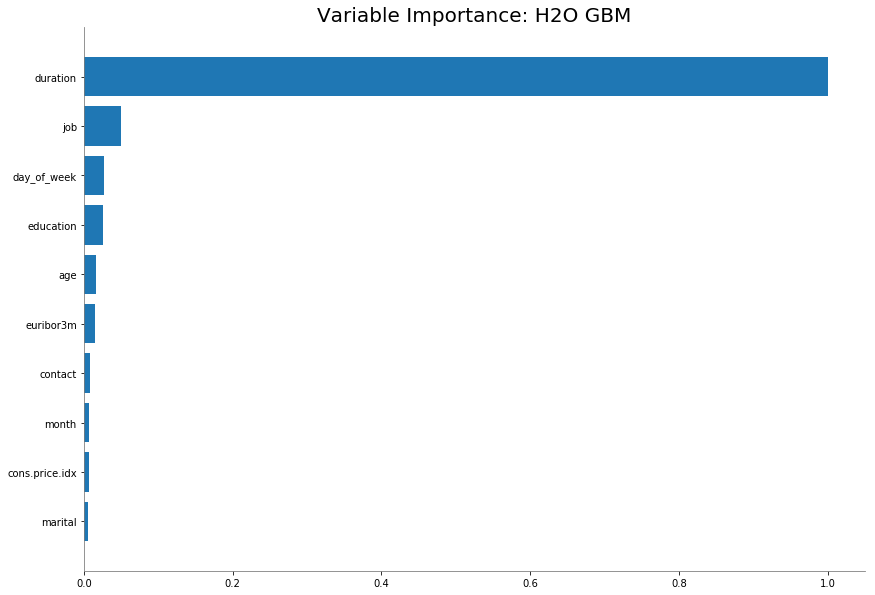

In [34]:
%matplotlib inline
best_model.varimp_plot()

We can examine the top two variables using Partial Dependence plots.  We can see that as `duration` increases the probability that `y = yes` increases. 

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


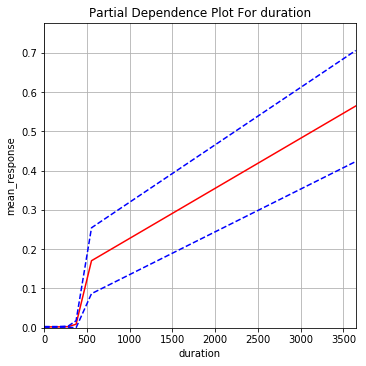

In [47]:
# decile bins for PDP
bins = list(train["duration"].quantile(prob = [0.1*i for i in range(0, 11)]).as_data_frame().iloc[:, 1])
best_model.partial_plot(train, cols=["duration"], figsize=(5, 5), user_splits={'duration': bins});

We can see from the table below that jobs like `admin` and `management` have a higher likelihood of `y = yes`.

In [58]:
best_model.partial_plot(train, cols=["job"], figsize=(5, 5), plot=False)

PartialDependencePlot progress: |█████████████████████████████████████████| 100%

PartialDependence: Partial Dependence Plot of model gbm_grid_model_2 on column 'job'


,job,mean_response,stddev_response,std_error_mean_response
0,admin.,0.050270,0.143574,0.001170
1,blue-collar,0.045342,0.132850,0.001082
2,entrepreneur,0.045383,0.121308,0.000988
3,housemaid,0.033160,0.092855,0.000756
4,management,0.050081,0.142702,0.001163
5,retired,0.041673,0.123187,0.001004
6,self-employed,0.032322,0.092733,0.000755
7,services,0.045380,0.125427,0.001022
8,student,0.030099,0.089170,0.000726
9,technician,0.045101,0.124222,0.001012


[]

## Shutdown the Cluster

In [59]:
h2o.cluster().shutdown()

H2O session _sid_a703 closed.
